In [17]:
from pyannote.audio import Pipeline
pipeline = Pipeline.from_pretrained('pyannote/speaker-diarization-community-1')

diarization = pipeline('cocktail_party_sample.wav')

for turn, speaker in diarization.speaker_diarization:
    print(f"{speaker} speaks between t={turn.start:.4f}s and t={turn.end:.4f}s")

/home/tancrede/.config/matplotlib is not a writable directory
Matplotlib created a temporary cache directory at /tmp/matplotlib-mqci4glv because there was an issue with the default path (/home/tancrede/.config/matplotlib); it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.
/home/tancrede/miniconda3/envs/voice_hack/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/tancrede/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannote/audio/models/blocks/pooling.py:103: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at /pytorch/aten/src/ATen/nati

SPEAKER_00 speaks between t=6.7303s and t=6.7472s
SPEAKER_01 speaks between t=6.7472s and t=7.0341s
SPEAKER_00 speaks between t=7.0341s and t=7.1860s
SPEAKER_00 speaks between t=7.5910s and t=7.6078s
SPEAKER_01 speaks between t=7.6078s and t=8.3166s
SPEAKER_00 speaks between t=8.3166s and t=9.9197s
SPEAKER_01 speaks between t=9.9197s and t=10.9828s
SPEAKER_00 speaks between t=10.4597s and t=14.7460s
SPEAKER_01 speaks between t=14.3072s and t=17.8847s
SPEAKER_00 speaks between t=18.0197s and t=21.5128s
SPEAKER_01 speaks between t=18.1547s and t=18.4416s
SPEAKER_01 speaks between t=21.7660s and t=28.4991s
SPEAKER_00 speaks between t=27.8578s and t=29.9672s


In [45]:
import os
from pyannoteai.sdk import Client
import librosa
import numpy as np

key_diarization = 'sk_61204b001ca5445981c96dacf5416515'

SAMPLE_RATE = 48000
CHUNK_DURATION = 2.0 # How to choose this
CHUNK_SIZE = int(SAMPLE_RATE * CHUNK_DURATION)
overlap_duration = 0.5 # min duration of overlap to run the separation

y, sr = librosa.load('cocktail_party_sample.wav', sr=SAMPLE_RATE)
audio_data = np.ascontiguousarray(y)
n_samples = len(audio_data)

client_diarization = Client(key_diarization)
job_id = client_diarization.diarize(client_diarization.upload('cocktail_party_sample.wav'))
diarization = client_diarization.retrieve(job_id)

segments = diarization['output']['diarization']
overlap_mask = np.zeros(n_samples, dtype=np.float32)
for i, seg_i in enumerate(segments):
    # only overlaps involving target speaker
    if seg_i["speaker"] != 'SPEAKER_00':
        continue

    for j, seg_j in enumerate(segments):
        if i!=j:
            # intersection
            overlap_start = max(seg_i["start"], seg_j["start"])
            overlap_end = min(seg_i["end"], seg_j["end"])

            if overlap_start >= overlap_end:
                continue  # no overlap
            else:
                print("overlap detected")
                # time → samples
                start_sample = int(overlap_start * SAMPLE_RATE)
                end_sample = int(overlap_end * SAMPLE_RATE)
                print(end_sample)

                start_sample = max(0, start_sample)
                end_sample = min(n_samples, end_sample)
                print(f"overlap between {start_sample / SAMPLE_RATE} and {end_sample / SAMPLE_RATE}")
                overlap_mask[start_sample:end_sample] = 1.0

overlap detected
399599
overlap between 8.305 and 8.324979166666667
overlap detected
483120
overlap between 9.865 and 10.065
overlap detected
527280
overlap between 10.565 and 10.985
overlap detected
706800
overlap between 14.305 and 14.725
overlap detected
891120
overlap between 18.085 and 18.565
overlap detected
1370160
overlap between 27.865 and 28.545


/home/emiliopicard/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannoteai/sdk/client.py:589: UserWarning: 
You are using periodic polling to retrieve results. 
If you are running in production, we highly recommend to setup a webhook server to obtain results faster, as soon as they are available. 
Please check our documentation at https://docs.pyannote.ai/ for more information.
  warnings.warn("""


In [39]:
import numpy as np
import librosa
SAMPLE_RATE = 48000

segments = []
y, sr = librosa.load('cocktail_party_sample.wav', sr=SAMPLE_RATE)
audio_data = np.ascontiguousarray(y)
print(len(audio_data))
n_samples = len(audio_data)
overlap_mask = np.zeros(n_samples, dtype=np.float32)
for turn, speaker in diarization.speaker_diarization:
    segments.append({
        "start": turn.start,
        "end": turn.end,
        "speaker": speaker
    })
print(segments)
for i, seg_i in enumerate(segments):
    # only overlaps involving target speaker
    if seg_i["speaker"] != 'SPEAKER_00':
        continue

    for j, seg_j in enumerate(segments):
        if i!=j:
            # intersection
            overlap_start = max(seg_i["start"], seg_j["start"])
            overlap_end = min(seg_i["end"], seg_j["end"])

            if overlap_start >= overlap_end:
                continue  # no overlap
            else:
                print("overlap detected")
                # time → samples
                start_sample = int(overlap_start * SAMPLE_RATE)
                end_sample = int(overlap_end * SAMPLE_RATE)
                print(end_sample)

                start_sample = max(0, start_sample)
                end_sample = min(n_samples, end_sample)
                print(f"overlap between {start_sample / SAMPLE_RATE} and {end_sample / SAMPLE_RATE}")
                overlap_mask[start_sample:end_sample] = 1.0

1440000
[{'start': 6.730343750000001, 'end': 6.74721875, 'speaker': 'SPEAKER_00'}, {'start': 6.74721875, 'end': 7.03409375, 'speaker': 'SPEAKER_01'}, {'start': 7.03409375, 'end': 7.185968750000001, 'speaker': 'SPEAKER_00'}, {'start': 7.59096875, 'end': 7.607843750000001, 'speaker': 'SPEAKER_00'}, {'start': 7.607843750000001, 'end': 8.316593750000003, 'speaker': 'SPEAKER_01'}, {'start': 8.316593750000003, 'end': 9.919718750000001, 'speaker': 'SPEAKER_00'}, {'start': 9.919718750000001, 'end': 10.98284375, 'speaker': 'SPEAKER_01'}, {'start': 10.45971875, 'end': 14.745968750000003, 'speaker': 'SPEAKER_00'}, {'start': 14.30721875, 'end': 17.88471875, 'speaker': 'SPEAKER_01'}, {'start': 18.01971875, 'end': 21.512843750000002, 'speaker': 'SPEAKER_00'}, {'start': 18.15471875, 'end': 18.44159375, 'speaker': 'SPEAKER_01'}, {'start': 21.765968750000003, 'end': 28.49909375, 'speaker': 'SPEAKER_01'}, {'start': 27.85784375, 'end': 29.96721875, 'speaker': 'SPEAKER_00'}]
overlap detected
527176
overla

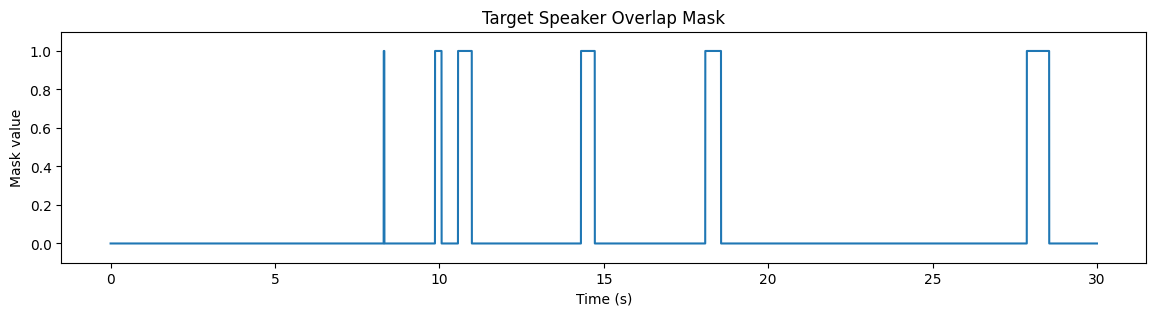

In [46]:
import matplotlib.pyplot as plt
import numpy as np

t = np.arange(len(overlap_mask)) / sr  # time axis in seconds

plt.figure(figsize=(14, 3))
plt.plot(t, overlap_mask)
plt.xlabel("Time (s)")
plt.ylabel("Mask value")
plt.title("Target Speaker Overlap Mask")
plt.ylim(-0.1, 1.1)
plt.show()

480000


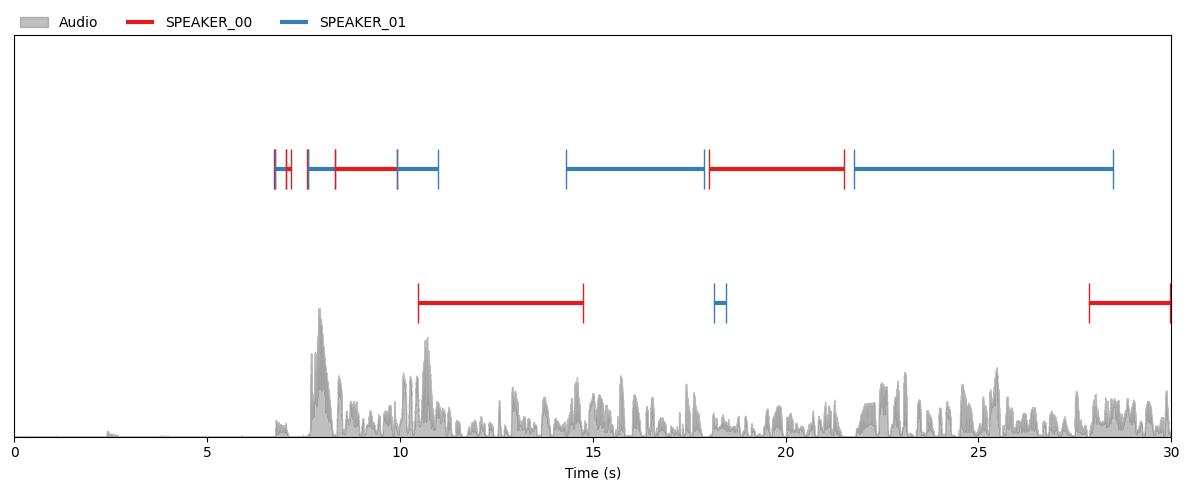

In [26]:
import matplotlib.pyplot as plt
import librosa
import librosa.display
from pyannote.core import Segment, notebook

audio_path = 'cocktail_party_sample.wav'

annotation = diarization.speaker_diarization
y, sr = librosa.load(audio_path, sr=None)
duration = librosa.get_duration(y=y, sr=sr)
notebook.crop = Segment(0, duration)

fig, ax = plt.subplots(figsize=(12, 5))

librosa.display.waveshow(y, sr=sr, ax=ax, alpha=0.5, color="gray", label="Audio")
notebook.plot_annotation(annotation, ax=ax, time=True, legend=True)

ax.set_xlabel("Time (s)")

plt.tight_layout()
plt.show()

Found 4!
Overlap detected from 10.5s to 11.0s
Overlap detected from 14.3s to 14.7s
Overlap detected from 18.2s to 18.4s
Overlap detected from 27.9s to 28.5s


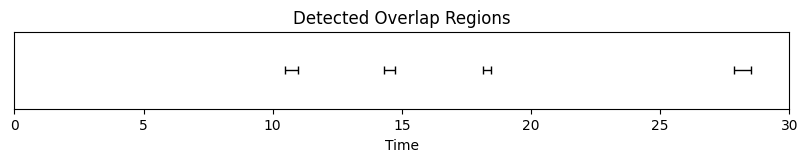

In [3]:
overlaps = annotation.get_overlap() # pyannote.core.annotation
print(f"Found {len(overlaps)}!")
for segment in overlaps:
    print(f"Overlap detected from {segment.start:.1f}s to {segment.end:.1f}s")

plt.figure(figsize=(10, 1))
notebook.plot_timeline(overlaps, time=True)
plt.title("Detected Overlap Regions")
plt.show()

In [ ]:
#
# Copyright 2018-2025 Picovoice Inc.
#
# You may not use this file except in compliance with the license. A copy of the license is located in the "LICENSE"
# file accompanying this source.
#
# Unless required by applicable law or agreed to in writing, software distributed under the License is distributed on
# an "AS IS" BASIS, WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied. See the License for the
# specific language governing permissions and limitations under the License.
#

from confidential import PORCUPINE_ACCESS_KEY
import os
import struct
import wave
from datetime import datetime

import pvporcupine
from pvrecorder import PvRecorder


def main(): 
    access_key = PORCUPINE_ACCESS_KEY
    keywords = ['porcupine']
    keyword_paths = None
    device = 'cuda:0'
    sensitivities = None # = 0.8
    model_path = None
    library_path = None
    audio_device_index = -1
    output_path = None
    show_audio_devices = True

    if show_audio_devices:
        for i, device in enumerate(PvRecorder.get_available_devices()):
            print('Device %d: %s' % (i, device))
        

    if keyword_paths is None:
        if keywords is None:
            raise ValueError("Either `--keywords` or `--keyword_paths` must be set.")

        keyword_paths = [pvporcupine.KEYWORD_PATHS[x] for x in keywords]
    else:
        keyword_paths = keyword_paths

    if sensitivities is None:
        sensitivities = [0.5] * len(keyword_paths)

    if len(keyword_paths) != len(sensitivities):
        raise ValueError('Number of keywords does not match the number of sensitivities.')
    try:
        porcupine = pvporcupine.create(
            access_key=access_key,
            library_path=library_path,
            model_path=model_path,
            # device=device,
            keyword_paths=keyword_paths,
            sensitivities=sensitivities)
    except pvporcupine.PorcupineInvalidArgumentError as e:
        print("One or more arguments provided to Porcupine is invalid: ")
        print(e)
        raise e
    except pvporcupine.PorcupineActivationError as e:
        print("AccessKey activation error")
        raise e
    except pvporcupine.PorcupineActivationLimitError as e:
        print("AccessKey '%s' has reached it's temporary device limit" % access_key)
        raise e
    except pvporcupine.PorcupineActivationRefusedError as e:
        print("AccessKey '%s' refused" % access_key)
        raise e
    except pvporcupine.PorcupineActivationThrottledError as e:
        print("AccessKey '%s' has been throttled" % access_key)
        raise e
    except pvporcupine.PorcupineError as e:
        print("Failed to initialize Porcupine")
        raise e

    keywords = list()
    for x in keyword_paths:
        keyword_phrase_part = os.path.basename(x).replace('.ppn', '').split('_')
        if len(keyword_phrase_part) > 6:
            keywords.append(' '.join(keyword_phrase_part[0:-6]))
        else:
            keywords.append(keyword_phrase_part[0])

    print('Porcupine version: %s' % porcupine.version)

    recorder = PvRecorder(
        frame_length=porcupine.frame_length,
        device_index=audio_device_index)
    recorder.start()

    wav_file = None
    if output_path is not None:
        wav_file = wave.open(output_path, "w")
        wav_file.setnchannels(1)
        wav_file.setsampwidth(2)
        wav_file.setframerate(16000)

    print('Listening ... (press Ctrl+C to exit)')

    try:
        while True:
            pcm = recorder.read()
            result = porcupine.process(pcm)
            if wav_file is not None:
                wav_file.writeframes(struct.pack("h" * len(pcm), *pcm))

            if result >= 0:
                print('[%s] Detected %s' % (str(datetime.now()), keywords[result]))
    except KeyboardInterrupt:
        print('Stopping ...')
    finally:
        recorder.delete()
        porcupine.delete()
        if wav_file is not None:
            wav_file.close()


if __name__ == '__main__':
    main()

In [5]:
from confidential import PYANNOTEAI_API_KEY

access_key = PYANNOTEAI_API_KEY
sample_file = 'cocktail_party_sample.wav'


# instantiate client
from pyannoteai.sdk import Client
client = Client(access_key)

# upload conversation file
media_url = client.upload(sample_file)

# submit a diarization job
job_id = client.diarize(media_url)

# retrieve diarization
diarization = client.retrieve(job_id)
diarization['output']['diarization'] #contains diarization output


[{'speaker': 'SPEAKER_00', 'start': 6.685, 'end': 7.165},
 {'speaker': 'SPEAKER_01', 'start': 7.565, 'end': 8.325},
 {'speaker': 'SPEAKER_00', 'start': 8.305, 'end': 10.065},
 {'speaker': 'SPEAKER_01', 'start': 9.865, 'end': 10.985},
 {'speaker': 'SPEAKER_00', 'start': 10.565, 'end': 14.725},
 {'speaker': 'SPEAKER_01', 'start': 14.305, 'end': 17.865},
 {'speaker': 'SPEAKER_00', 'start': 18.045, 'end': 21.505},
 {'speaker': 'SPEAKER_01', 'start': 18.085, 'end': 18.565},
 {'speaker': 'SPEAKER_01', 'start': 21.765, 'end': 28.545},
 {'speaker': 'SPEAKER_00', 'start': 27.865, 'end': 29.985}]

In [6]:
import sounddevice as sd

for i, dev in enumerate(sd.query_devices()):
    print(i, dev['name'], "(Input channels:", dev['max_input_channels'], ")")


In [12]:
import time
import sounddevice as sd
import numpy as np
import wave
from pyannoteai.sdk import Client
from confidential import PYANNOTEAI_API_KEY

# -------------------------------   
# Config
# -------------------------------
access_key = PYANNOTEAI_API_KEY
SAMPLE_RATE = 16000  # Hz
CHANNELS = 1
RECORD_SECONDS = 10
TEMP_FILE = sample_file#"temp_speaker.wav"

# -------------------------------
# Step 1: Record audio when speaker starts
# -------------------------------
print("Listening for speaker to start...")

# Threshold to detect voice (adjust as needed)
THRESHOLD = 0.01

def detect_voice(indata):
    """Return True if voice is detected in the frame"""
    volume_norm = np.linalg.norm(indata) / len(indata)
    return volume_norm > THRESHOLD

recorded_audio = []

def callback(indata, frames, time_info, status):
    global recorded_audio, recording_started
    if detect_voice(indata) and not recording_started:
        print("Speaker detected! Starting 10-second recording...")
        recording_started = True
        recorded_audio.append(indata.copy())
        callback.start_time = time.time()
    elif recording_started:
        recorded_audio.append(indata.copy())
        # Stop after 10 seconds
        if time.time() - callback.start_time >= RECORD_SECONDS:
            raise sd.CallbackStop()

recording_started = False
callback.start_time = None

# with sd.InputStream(samplerate=SAMPLE_RATE, channels=CHANNELS, callback=callback, dtype="float32"):
#     sd.sleep(60_000)  # maximum wait 60 seconds for a speaker
recorded_audio=[[1,2,4,5]]
# Convert recorded audio to a single numpy array
audio_np = np.concatenate(recorded_audio, axis=0)

# Save temporary WAV
wav_file = wave.open(TEMP_FILE, 'w')
wav_file.setnchannels(CHANNELS)
wav_file.setsampwidth(2)  # 16-bit PCM
wav_file.setframerate(SAMPLE_RATE)
# Convert float32 -> int16
audio_int16 = np.int16(audio_np * 32767)
wav_file.writeframes(audio_int16.tobytes())
wav_file.close()

print(f"Audio recorded to {TEMP_FILE}")

# -------------------------------
# Step 2: Retrieve speaker embedding with Pyannote
# -------------------------------
client = Client(access_key)

# Upload audio
media_url = client.upload(TEMP_FILE)

# Submit embedding job
job_id = client.voiceprint(media_url)

# Retrieve embedding
embedding_result = client.retrieve(job_id)

# speaker_embed variable
speaker_embed = embedding_result['output']['voiceprint']

print("Speaker embedding retrieved:", speaker_embed)
print("Shape:", np.array(speaker_embed).shape)


Listening for speaker to start...
Audio recorded to cocktail_party_sample.wav


/home/tancrede/miniconda3/envs/voice_hack/lib/python3.10/site-packages/pyannoteai/sdk/client.py:356: UserWarning: 
You are using pyannoteAI's temporary storage solution. Your file will be permanently deleted from our servers within 24hs. 
If you are running in production, we highly recommend to use your own storage to reduce network latency and obtain results faster. 
Please check our documentation at https://docs.pyannote.ai/ for more information.
  warnings.warn("""


PyannoteAIFailedJob: ('Could not compute voiceprint because no speech has been detected.', '387b5689-37f3-4312-bf1b-8289dd5055e7')

In [ ]:
# upload conversation file
media_url = client.upload(sample_file)

# submit a diarization job
job_id = client.voiceprint(media_url)

# retrieve diarization
diarization = client.retrieve(job_id)
diarization['output']['voiceprint'] #contains diarization output